2020/10/15

-------------------------------------
# Serverless XGBoost

There are many ways that data scientists can contribute to the projects or companies they work with. Arguably, one of the biggest contributions that a data scientist can make is to deploy a model that makes inference in real-time on an online setting. 

When it comes to deploying models, such as XGBoost models, there are various tools that allow you to achieve the same and ultimate goal: online inference. This tutorial will illustrate my favorite choice in the context of XGBoost.

In this tutorial, we'll show how to deploy a XGBoost model using technologies with a low learning curve, very reliable, secure, scalable, and affordable.

The reasons for me that made of this approach the one that best suits my use cases as a Data Scientist, is due to the following advantages:

- There is no need to install any package in the production environment.
- It is very affordable for all project sizes.
- It is powered by cloud computing solutions that made it very scalable.

## Summary

In Section 1 we'll show how to train a XGBoost model and how to save it in JSON format.

In Section 2, we'll show how to deploy the JSON model to a production environment.

Finally, in Section 3 we show how this approach is scalable and affordable.


# Section 1: Fit a XGBoost binary classifier and get scores with pure python code.

In this section we'll fit a binary XGBoost classifier to the Breast Cancer dataset.

In the dataset, we will artificially insert a few `NaN` values. This will allow us to demonstrate the correct handlying of missing values by our pure python code. Also, our training data matrix will be composed of a `pandas.DataFrame`, this is desirable in order for the split nodes in the XGBoost trees contain the feature names, which will make our tree structure a bit more human readable.

We'll train our model using early stopping in order to show how to correctly fetch scores from the top-N trees of the ensemble.

The resulting model will be saved in JSON format insead to the classic pickle format. By saving the model as a JSON instead of using Pickle format will allow us to skip the XGBoost instalation in our production setting.

## Step 1: Fit a XGBoost Binary Classifier.
First read the data as a `pandas.DataFrame`:

In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import json

from sklearn import datasets
from sklearn.model_selection import train_test_split

dataset = datasets.load_breast_cancer()
X = pd.DataFrame(
    dataset.data,
    columns=[x.replace(' ', '_') for x in dataset.feature_names])
y = dataset.target

X.shape

(569, 30)

Then insert a few `NaN` values (this is done solely to demonstrate the correct handlying of missing values):

In [2]:
nan_count_original = X.isnull().sum().sum()
for col in X.columns:
    X.loc[
        X[col] <= X[col].quantile(.3),
        col] = np.nan
nan_count_artificial = X.isnull().sum().sum()

print('NaN values count in original dataset: %s' % nan_count_original)
print('NaN values count in artificial dataset: %s' % nan_count_artificial)

NaN values count in original dataset: 0
NaN values count in artificial dataset: 5133


Then train a xgboost model using early stopping:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

model = xgb.XGBClassifier(n_estimators=500)

model.fit(
    X_train, y_train,
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)])

[0]	validation_0-error:0.052632
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.052632
[2]	validation_0-error:0.052632
[3]	validation_0-error:0.052632
[4]	validation_0-error:0.040936
[5]	validation_0-error:0.052632
[6]	validation_0-error:0.040936
[7]	validation_0-error:0.052632
[8]	validation_0-error:0.046784
[9]	validation_0-error:0.064327
[10]	validation_0-error:0.052632
[11]	validation_0-error:0.064327
[12]	validation_0-error:0.05848
[13]	validation_0-error:0.064327
[14]	validation_0-error:0.064327
Stopping. Best iteration:
[4]	validation_0-error:0.040936



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Once trained, save the model in JSON format. 
In our case we have cloned this repository in the following path: `'~/chalice_xgboost/'`, and therefore, the path where we'll like to save the model dump is in the `~/chalice/chalicelib/models/` folder.

In [4]:
MODEL_FOLDER_PATH = os.path.expanduser(
    '~/chalice_xgboost/chalicelib/models/')

MODEL_FILE_PATH = os.path.join(
    MODEL_FOLDER_PATH, 'xgb.json')

# Make folder path if it does not exists.
os.makedirs(
    MODEL_FOLDER_PATH,
    exist_ok=True)

# Save dump of trees as .json
model._Booster.dump_model(
    MODEL_FILE_PATH,
    dump_format='json')

In the previous step, we had saved the entire ensemble of trees, however, by fetching scores manually we will only need the top best n-trees chose by the early-stopping feature. As the entire ensemble can be found in the json dump, we'll remove the unnecesary trees. This is done by loading the model ensemble, subset the desired numbers of trees, and overwriting the file where the model was saved:

In [5]:
# Load the model dump.
with open(MODEL_FILE_PATH, 'r') as f:
    model_json = json.loads(f.read())
print('Number of trees: %s' % len(model_json))

# Subset the ensemple to the best n-trees.
model_json = model_json[:model.best_ntree_limit]
print('Number of top-n best trees: %s' % len(model_json))

# Overwrite the dump with only the best n-trees.
with open(MODEL_FILE_PATH, 'w') as f:
    f.write(json.dumps(model_json))

Number of trees: 15
Number of top-n best trees: 5


The structure of the model ensemble of trees is pretty simple. It consist of a `list` of python `dict`s, where each item on the list corresponds to a single tree. Bellow can be found the first tree in the ensemble, in order for you to get familiar with the structure:

In [6]:
model_json[0]

{'nodeid': 0,
 'depth': 0,
 'split': 'worst_concave_points',
 'split_condition': 0.142349988,
 'yes': 1,
 'no': 2,
 'missing': 1,
 'children': [{'nodeid': 1,
   'depth': 1,
   'split': 'worst_radius',
   'split_condition': 17.6149998,
   'yes': 3,
   'no': 4,
   'missing': 3,
   'children': [{'nodeid': 3,
     'depth': 2,
     'split': 'area_error',
     'split_condition': 35.2600021,
     'yes': 7,
     'no': 8,
     'missing': 7,
     'children': [{'nodeid': 7, 'leaf': 0.189830512},
      {'nodeid': 8, 'leaf': 0.0545454584}]},
    {'nodeid': 4,
     'depth': 2,
     'split': 'mean_texture',
     'split_condition': 19.1650009,
     'yes': 9,
     'no': 10,
     'missing': 9,
     'children': [{'nodeid': 9, 'leaf': 0},
      {'nodeid': 10, 'leaf': -0.138461545}]}]},
  {'nodeid': 2,
   'depth': 1,
   'split': 'worst_perimeter',
   'split_condition': 97.4900055,
   'yes': 5,
   'no': 6,
   'missing': 5,
   'children': [{'nodeid': 5, 'leaf': 0.0181818195},
    {'nodeid': 6,
     'depth': 

As observed, each tree is composed of and initial node, and each node may have further nested nodes with can be found under the `children` key. 

The keys: `split` and `split_condition`, are the feature-name and feature-value of the split condition respectively. A final node, that has no further childre, correspond to a leaf node and has a `leaf` value, which is some sort of a fraction of the models prediction score.

Bellow, you can find the tree diagram, where you can corroborate the correctness of the structure above.

In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in 

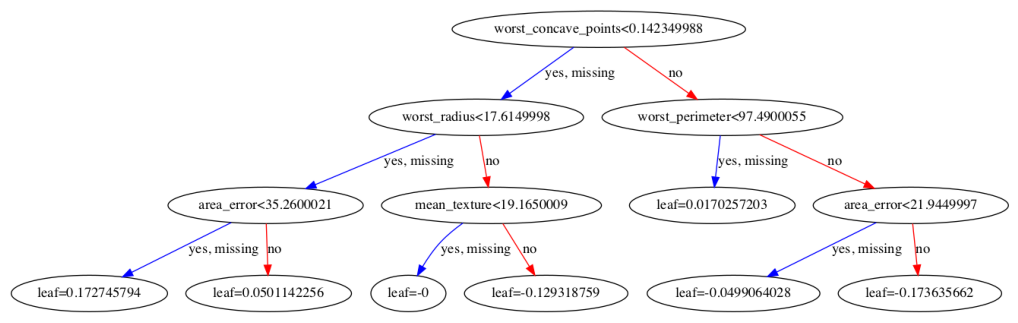

In [7]:
%matplotlib inline

from xgboost import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax = plot_tree(
    model, 
    num_trees=1, 
    ax=ax)

## **Step 2**: Get model scores from the model json dump.

In this section we describe two methods that will allow us to fetch model scores with pure python code.

The first method, namely `get_tree_leaf()` allow us to fetch a single tree leaf score value.
And the second method: `binary_predict_proba()` allow us to iteratively fetch model scores, sum them up and get the final probability score.

Both methods are well documented, feel free to take your time to understand the logic, which is pretty straigh forward.

In [8]:
import math

def get_tree_leaf(node, x):
    """Get tree leaf score.
    
    Each node contains children that are composed of aditiona nodes.
    Final nodes with no children are the leaves.
    
    Parameters
    -----------
    node: dict
        Node XGB dictionary.
    x: dict
        Dictionary containing feature names and feature values.
    
    Return
    -------
    score: float
        Leaf score.
    """

    if 'leaf' in node:
        # If the leaf key is found, stop the recurrency.
        score = node['leaf']
        return score
    else:
        # Get current split feature value
        x_f_val = x[node['split']]

        # Get next node.
        if str(x_f_val) == 'nan':
            # if split feature value is nan.
            next_node_id = node['missing']
        elif x_f_val < node['split_condition']:
            # Split condition is true.
            next_node_id = node['yes']
        else:
            # Split condition is false.
            next_node_id = node['no']

        # Get the next node.
        for children in node['children']:
            if children['nodeid'] == next_node_id:
                return get_tree_leaf(children, x)


def binary_predict_proba(x, model_json):
    """Get the score of a binary xgboost classifier.
    
    Parameters
    ----------
    x: dict
        Dictionary containing feature names and feature values.
    
    model_json: dict
        Dump of xgboost trees as json.
    
    Returns
    -------
    y_score: list
        Probability scores of the negative and positve class.
    """
    
    # Get tree leafs.
    tree_leaf_scores = []
    for tree in model_json:
        leaf_score = get_tree_leaf(
            node=tree,
            x=x)
        tree_leaf_scores.append(leaf_score)

    # Get logistic function logit.
    logit = sum(tree_leaf_scores)
    
    # Compute the logistic function
    pos_class_probability = 1 / (1 + math.exp(-logit))

    # Get negative and positive class probabilities.
    y_score = [1 - pos_class_probability, pos_class_probability]
    
    return y_score

Using the functions above, we obtain the scores using pure python code and the model json dump:

In [9]:
import json

# Model object
with open(MODEL_FILE_PATH, 'r') as f:
    model_json = json.loads(f.read())

y_scores_json = pd.Series([
    binary_predict_proba(x.to_dict(), model_json)[1]
    for _, x in X_test.iterrows()])

y_scores_json.head()

0    0.303801
1    0.694275
2    0.694275
3    0.694275
4    0.694275
dtype: float64

The scores fetched manully are the same to the scores obtained from the `xgboost.XGBClassifier` model, as shown bellow:

In [10]:
y_scores_model = pd.Series(model.predict_proba(
    X_test
)[:, 1])

y_scores_model.head()

0    0.303801
1    0.694275
2    0.694275
3    0.694275
4    0.694275
dtype: float32

Also, notice the correctness of the score in the presence of `NaN` values:

In [11]:
x_nan = pd.DataFrame(
    [[np.nan for _ in X.columns]],
    columns=X.columns)
x_nan

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
binary_predict_proba(x_nan.iloc[0].to_dict(), model_json)[1]

0.6942748733787976

In [13]:
model.predict_proba(x_nan)[0, 1]

0.69427484

## Conclusion
In this section we have show how to create a XGBoost model, saved it as a JSON set of trees and how to get model probabilities scores using pure python code.

# Section 2: Use Chalice to deploy your model.

In this section, we will use Chalice in order to deploy our serverless infrastructure in AWS. 

(NOTE: Explain what is Chalice)

You will first need to set up your AWS credentials as shown in the following [link](https://chalice.readthedocs.io/en/stable/quickstart.html#credentials), if it is your first time using AWS, don't worry, you'll basically have to create an account and get some credentials in order for you being able to take control of the cloud solutions provided by AWS programatillay.

Once your AWS account and your credentials are all in place, we will only need to:

- Create a new python environment and install the `chalice` package.
- Clone the repository.
- Local test and deploy to production.

## Create a new python environment and install the `chalice` package.

First, create a python environment. You can use your favorite environment management tool, in this example I'll use conda:
```
$ conda create --name chalice_xgboost python=3.7.3
$ conda activate chalice_xgboost
(chalice_xgboost) $
```

Then install chalice package:
```
(chalice_xgboost) $ pip install chalice
```

## Clone the repository.

In this section we'll clone the chalice project that contains our XGboost model dump, and place the terminal under the folder `chalice_xgboost`:

``` 
(chalice_xgboost) $ git clone git@github.com:RaulSanchezVazquez/chalice_xgboost.git
(chalice_xgboost) $ cd chalice_xgboost
```

(NOTE: Explain the folders)
```
(chalice_xgboost) chalice_xgboost $ ls
README.ipynb README.md    app.py       chalicelib   models
```

## Local test and deploy to production.

Run locally the server:

```
(chalice_xgboost) chalice_xgboost $ chalice local
Serving on http://127.0.0.1:8000
```

The `app.py` file 


```python
# Get model score.
@app.route('/predict_proba', methods=['POST'])
def get_decision():
    """Get model score.
    """
    # Get body
    body = app.current_request.json_body

    # Get features from the request
    x = body['x']
    log.LOGGER_.info('x: %s' % x)

    # Load the model.
    model_json = model.get()
    log.LOGGER_.info('Model loaded: %s Trees' % len(model_json))

    # Get decision thresholds.
    y_score = xgb.binary_predict_proba(x, model_json)
    log.LOGGER_.info('y_score: %s' % y_score)

    # Get response
    response = {'y_score': y_score}
    log.LOGGER_.info('response: %s' % response)

    return {'response': response}
```


With the server running locally, send a POST http request, and fetch the score:

In [14]:
x = X_test.iloc[0].to_dict()
x

{'mean_radius': 13.4,
 'mean_texture': 20.52,
 'mean_perimeter': 88.64,
 'mean_area': 556.7,
 'mean_smoothness': 0.1106,
 'mean_compactness': 0.1469,
 'mean_concavity': 0.1445,
 'mean_concave_points': 0.08172,
 'mean_symmetry': 0.2116,
 'mean_fractal_dimension': 0.07325,
 'radius_error': 0.3906,
 'texture_error': 0.9306,
 'perimeter_error': 3.093,
 'area_error': 33.67,
 'smoothness_error': nan,
 'compactness_error': 0.02265,
 'concavity_error': 0.03452,
 'concave_points_error': 0.01334,
 'symmetry_error': 0.01705,
 'fractal_dimension_error': 0.004005,
 'worst_radius': 16.41,
 'worst_texture': 29.66,
 'worst_perimeter': 113.3,
 'worst_area': 844.4,
 'worst_smoothness': 0.1574,
 'worst_compactness': 0.3856,
 'worst_concavity': 0.5106,
 'worst_concave_points': 0.2051,
 'worst_symmetry': 0.3585,
 'worst_fractal_dimension': 0.1109}

In [15]:
import os
import json
import urllib3

http = urllib3.PoolManager()

ENDPOINT = 'http://127.0.0.1:8000'

body = {"x": x}

response = http.request(
     'POST',
     ENDPOINT + '/predict_proba',
     body=json.dumps(body).encode('utf-8'),
     headers={'Content-Type': 'application/json'})

response = json.loads(
    response.data.decode('utf-8'))

response

{'response': {'y_score': [0.6961988994898333, 0.30380110051016673]}}